<a href="https://colab.research.google.com/github/KLeeDE/PUS2020_KLee/blob/master/Project/20201130_Wilimington_oneper_blockg_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **SPPA667 HW9: Plots and Visualization**

Written by: @KLeeDE

Date: 11/10/2020

**Topic**: An Analysis on Flood Risk and Socio-Economic and Demographic Status

**Research Area**: Wilmington, Delaware


**Available data**

Wilmington data

1. Flood Depth Grid (2014/Raster/Federal Emergency Management Agency (FEMA)
*  CstDpthxxxpct: Coastal flood depth for the xxx percent
annual chance flood event. This raster is
required to be produced for coastal Flood
Risk Projects. [Feet]
*   CstDpth_01pct : Raster dataset of flood depth for a coastal 1% event. (1-percent-annualchance) [Feet]
*   Depth_01pct : Raster dataset of flood depth for a 1% event [Feet]

2. Census data Block Group (2010/CSV/U.S.Census Bureau)

3. Socioeconomic and Demographic (SED) data (2014 (ACS5) / Shapefile / U.S. Census Bureau)




**Additional rastar data description**

County
*   10001C: Kent County
*   10003C: New Castle County
*   10005C: Sussex County

Flood hazard is defined by a relation between depth of flooding and the annual chance of inundation greater than that depth.

Depth grid is defined by **the percent annual chance floods**. This is usually only **the 1% annual chance flood**.

# Original Plot

In [1]:
# -- mount drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# -- install geospatial packages
!sudo apt install libspatialindex-dev
!pip install rtree
!pip install geopandas
!pip install censusdata

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libspatialindex-c4v5 libspatialindex4v5
The following NEW packages will be installed:
  libspatialindex-c4v5 libspatialindex-dev libspatialindex4v5
0 upgraded, 3 newly installed, 0 to remove and 14 not upgraded.
Need to get 555 kB of archives.
After this operation, 3,308 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex4v5 amd64 1.8.5-5 [219 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex-c4v5 amd64 1.8.5-5 [51.7 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex-dev amd64 1.8.5-5 [285 kB]
Fetched 555 kB in 0s (4,886 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialo

In [3]:
import time
import geopandas as gp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gdal
from gdalconst import *
from shapely.geometry import Point
from collections import Counter
import censusdata

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = (15,10)

## Flood Depth data

In [4]:
# data: 1% depth / DE / coastal area / New Castle (10003C)
fname3C_Cst_Dpth01pct = "/content/drive/My Drive/flooding/data/FEMA_Coastal_GeoTIFFs/New  Castle/FRD_10003C_Coastal_GeoTIFFS_20140516/10003C_Coastal_CstDpth01pct.tif"
# read in a raster data
rast3C_Cst_Dpth01pct = gdal.Open(fname3C_Cst_Dpth01pct, GA_ReadOnly)
# extract raster to array
samp=100
arr3C_Cst_Dpth01pct = rast3C_Cst_Dpth01pct.ReadAsArray()[::samp, ::samp]
arr3C_Cst_Dpth01pct = arr3C_Cst_Dpth01pct.clip(0,10)
#arr3C_Cst_Dpth01pct = rast3C_Cst_Dpth01pct.ReadAsArray()

In [5]:
print(arr3C_Cst_Dpth01pct.shape)

(183, 102)


/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:488: RuntimeWarning: overflow encountered in multiply
  A_resampled *= ((a_max - a_min) / 0.8)


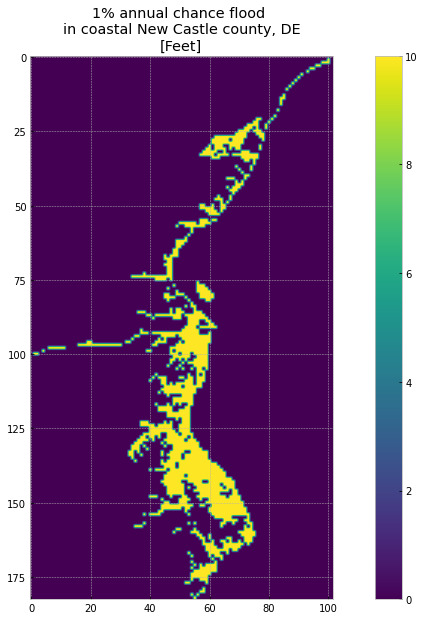

In [6]:
#  plot raster : 1% depth / DE / coastal area  
fig_raster, ax = plt.subplots()
im = ax.imshow(arr3C_Cst_Dpth01pct)

ax.imshow(rast3C_Cst_Dpth01pct.ReadAsArray()[::samp, ::samp])
ax.set_title("1% annual chance flood \nin coastal New Castle county, DE\n[Feet]")
fig_raster.colorbar(im)
plt.show()

**Fig1. Flood Depth Grid** Subtitle is the one percent annual chance flood in coastal New Castle County (Unit: Feet). Flood hazard is defined by a relation between depth of flooding and the annual chance of inundation greater than that depth. Depth grid is defined by the percent annual chance floods. This is usually only the 1% annual chance flood.This figure is  based on the raster data from the Federal Emergency Management Agency (FEMA) in 2014, which is the most recent available data in Delaware. 

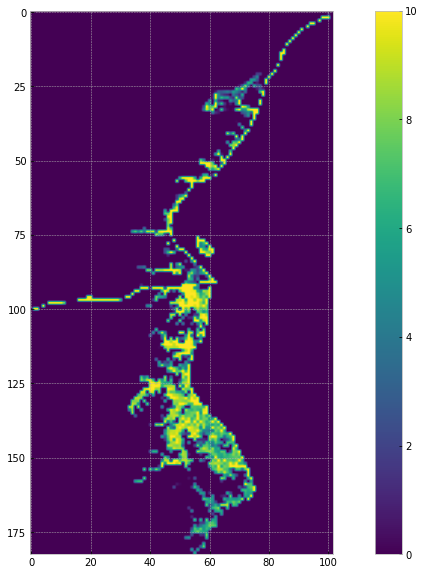

In [7]:
 # set Latitude/Longitude

# read in the meta data file as list of strings:
mname3c = "/content/drive/My Drive/flooding/data/FEMA_Coastal_GeoTIFFs/New  Castle/FRD_10003C_Coastal_GeoTIFFS_20140516/10003C_Coastal_CstDpth01pct.tif.xml"
fopen = open(mname3c, "r")
lines = [i for i in fopen]
fopen.close()

# get lat lon meta data
for line in lines:
  if "<westBL Sync=\"TRUE\">" in line:
    westBL = float(line.split("<westBL Sync=\"TRUE\">")[2].split("<")[0])

  if "<eastBL Sync=\"TRUE\">" in line:
    eastBL = float(line.split("<eastBL Sync=\"TRUE\">")[2].split("<")[0])

  if "<northBL Sync=\"TRUE\">" in line:
    northBL = float(line.split("<northBL Sync=\"TRUE\">")[2].split("<")[0])

  if "<southBL Sync=\"TRUE\">" in line:
    southBL = float(line.split("<southBL Sync=\"TRUE\">")[2].split("<")[0])

# get number of rows and cols
nrows3c, ncols3c = arr3C_Cst_Dpth01pct.shape

# create lat and lon arrays
# define upperleft and resolution
ul_r = northBL
ul_c = westBL
dr   = (northBL - southBL) / nrows3c
dc   = (eastBL - westBL) / ncols3c

# generate a grid of row and col indices
cols3c, rows3c = np.meshgrid(np.arange(ncols3c), np.arange(nrows3c))

lat_grid_3c = ul_r - rows3c * dr
lon_grid_3c = ul_c + cols3c * dc

# plt.imshow(lat_grid_3c)
# plt.colorbar()
# plt.hist(np.log10(arr1C_Cst_Dpth01pct[arr1C_Cst_Dpth01pct > 0]))

dep_grid_3c = arr3C_Cst_Dpth01pct
ax = plt.imshow(dep_grid_3c)
plt.colorbar()

# plt.hist(dep_grid_3c[dep_grid_3c > -1e38].flatten())

## Block Group shapefile

In [8]:
def label_plot(plot_axis, title, x_axis_label, y_axis_label, title_weight="bold", title_size=16, axis_weight="bold", axis_size=14 ):
  plot_axis.set_title(title, weight=title_weight, size=title_size)
  plot_axis.set_xlabel(x_axis_label, weight=axis_weight, size=axis_size)
  plot_axis.set_ylabel(y_axis_label, weight=axis_weight, size=axis_size)

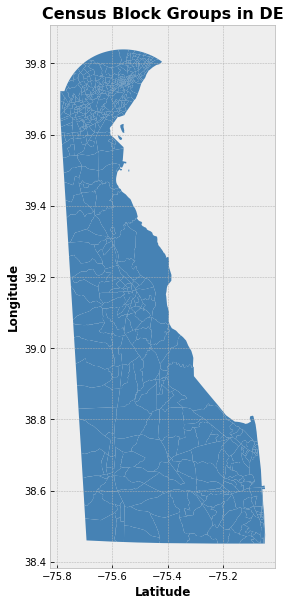

In [9]:
# load the census block group (2010)
cblkname = "/content/drive/My Drive/flooding/data/censusblock/Census_Block_Groups_2010/Census_Block_Groups_2010.shp"
decblkg_2010 = gp.read_file(cblkname)

# figure
fig_cblockg, ax = plt.subplots()
decblkg_2010.plot(color="steelblue", ax=ax)
label_plot(ax, "Census Block Groups in DE", "Latitude", "Longitude", axis_size=12, title_size=16)
fig_cblockg.savefig("/content/drive/My Drive/flooding/figure/sppa667")

**Fig 2. Census Block Groups** Subtitle is the census block groups in New Castle County. This figure is based on 2010 shapefile. Please note that the most recent data is 2016 but this figure is based on 2010 data to align with the other available data in this research. 

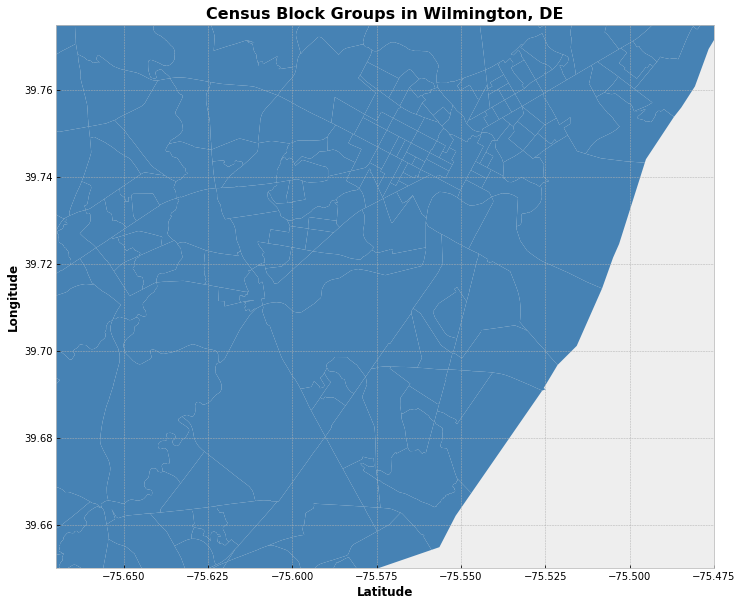

In [10]:
decblkg_2010_copy = decblkg_2010.copy()

fig_cblockg_wm, ax = plt.subplots()
decblkg_2010_copy.plot(color="steelblue", ax=ax)
ax.set_xlim(-75.67, -75.475)
ax.set_ylim(39.65, 39.775)
label_plot(ax, "Census Block Groups in Wilmington, DE", "Latitude", "Longitude", axis_size=12, title_size=16)

fig_cblockg_wm.savefig("/content/drive/My Drive/flooding/figure/sppa667")

## Socioeconomic demographic (SED) data 

In [11]:
# -- lablel plot
def label_plot(plot_axis, title, x_axis_label, y_axis_label, title_weight="bold", title_size=16, axis_weight="bold", axis_size=14 ):
  plot_axis.set_title(title, weight=title_weight, size=title_size)
  plot_axis.set_xlabel(x_axis_label, weight=axis_weight, size=axis_size)
  plot_axis.set_ylabel(y_axis_label, weight=axis_weight, size=axis_size)

#--Getting standardized values
def standardize(dataframe, original_column_name:str, intended_column_name:str):
  values = dataframe[original_column_name]
  values_mean = values.mean()
  values_stdev = values.std()
  standardized_values = []
  for i in values:
    standardized_values.append((i-values_mean)/values_stdev)
  dataframe[intended_column_name] = standardized_values

In [12]:
# -- Median household income by census block group : New Castle
censusdata.censustable('acs5', 2014, 'B19049')
censusdata.geographies(censusdata.censusgeo([('state', '*')]), 'acs5', 2014)
censusdata.geographies(censusdata.censusgeo([('state', '10'), ('county', '*')]), 'acs5', 2014)
income_cblkg = censusdata.download('acs5', 2014, censusdata.censusgeo([('state', '10'), ('county', '003'), ('block group', '*')]), ["B19049_001E"])
nc_income_cblkg  = pd.concat([censusdata.download('acs5', 2014, censusdata.censusgeo([('state', '10'), ('county', i), ('block group', '*')]), ["B19049_001E"]) for i in ["003"]])
nc_income_cblkg['mincome'] = nc_income_cblkg["B19049_001E"].clip(0,1e9).dropna() 
#--Getting standardized values
standardize(nc_income_cblkg, "mincome", "mincome_st")
nc_income_cblkg = nc_income_cblkg[["mincome", "mincome_st"]]
#--data description
print("Median household income in New Castle County, DE")
print(nc_income_cblkg.describe())

Median household income in New Castle County, DE
             mincome    mincome_st
count     368.000000  3.680000e+02
mean    67356.024457 -3.891814e-17
std     33026.081728  1.000000e+00
min         0.000000 -2.039480e+00
25%     45678.750000 -6.563683e-01
50%     61144.000000 -1.880945e-01
75%     83391.000000  4.855246e-01
max    209250.000000  4.296422e+00


In [13]:
# -- Racial factors (White alone / Total) by census block group
censusdata.censustable('acs5', 2014, 'B02001')
censusdata.geographies(censusdata.censusgeo([('state', '*')]), 'acs5', 2014)
censusdata.geographies(censusdata.censusgeo([('state', '10'), ('county', '*')]), 'acs5', 2014)
race_cblkg = censusdata.download('acs5', 2014, censusdata.censusgeo([('state', '10'), ('county', '003'), ('block group', '*')]), ["B02001_001E", "B02001_002E"])
nc_race_cblkg  = pd.concat([censusdata.download('acs5', 2014, censusdata.censusgeo([('state', '10'), ('county', i), ('block group', '*')]), ["B02001_001E", "B02001_002E"]) for i in ["003"]])
nc_race_cblkg['per_white'] = nc_race_cblkg["B02001_002E"] / nc_race_cblkg["B02001_001E"] * 100
nc_race_cblkg['per_nonwhite'] = (nc_race_cblkg["B02001_001E"] - nc_race_cblkg["B02001_002E"])/nc_race_cblkg["B02001_001E"] *100
nc_race_cblkg = nc_race_cblkg[['per_white', 'per_nonwhite']].clip(0,1e9).dropna()
#--Getting standardized values
standardize(nc_race_cblkg, "per_nonwhite", "per_nonwhite_st")
nc_race_cblkg = nc_race_cblkg[["per_nonwhite", "per_nonwhite_st"]]
#--data description
print("Percent of Not White in New Castle County, DE")
print(nc_race_cblkg.describe())

Percent of Not White in New Castle County, DE
       per_nonwhite  per_nonwhite_st
count    366.000000     3.660000e+02
mean      33.694627     9.591599e-16
std       27.510316     1.000000e+00
min        0.000000    -1.224800e+00
25%       11.243796    -8.160877e-01
50%       24.158250    -3.466473e-01
75%       50.777329     6.209562e-01
max      100.000000     2.410200e+00


In [14]:
# Poverty rate by census block group
censusdata.censustable('acs5', 2014, 'B17010')
censusdata.geographies(censusdata.censusgeo([('state', '*')]), 'acs5', 2014)
censusdata.geographies(censusdata.censusgeo([('state', '10'), ('county', '*')]), 'acs5', 2014)
poverty_cblkg = censusdata.download('acs5', 2014, censusdata.censusgeo([('state', '10'), ('county', '003'), ('block group', '*')]), ["B17010_001E", "B17010_002E"])
nc_poverty_cblkg  = pd.concat([censusdata.download('acs5', 2014, censusdata.censusgeo([('state', '10'), ('county', i), ('block group', '*')]), ["B17010_001E", "B17010_002E"]) for i in ["003"]])
nc_poverty_cblkg['per_below_povlev'] = nc_poverty_cblkg["B17010_002E"] / nc_poverty_cblkg["B17010_001E"] * 100
nc_poverty_cblkg = nc_poverty_cblkg[['per_below_povlev']].clip(0,1e9).dropna()
#--Getting standardized values
standardize(nc_poverty_cblkg, 'per_below_povlev', 'per_below_povlev_st')
nc_poverty_cblkg = nc_poverty_cblkg[["per_below_povlev", "per_below_povlev_st"]]
#--data description
print("Percent of People Under Poverty Line in New Castle County, DE")
print(nc_poverty_cblkg.describe())

Percent of People Under Poverty Line in New Castle County, DE
       per_below_povlev  per_below_povlev_st
count        365.000000         3.650000e+02
mean           9.214050         1.659631e-17
std           13.249521         1.000000e+00
min            0.000000        -6.954251e-01
25%            0.000000        -6.954251e-01
50%            3.773585        -4.106160e-01
75%           12.932790         2.806698e-01
max           82.666667         5.543794e+00


In [15]:
# -- Income Data : New Castle
# -- initialize GEOID container
geoids = []
# -- for each censusgeo, extract the Block Group GEOID (as type str)
for cgeo in nc_income_cblkg.index:
  geoids.append(cgeo.geo[0][1] + cgeo.geo[1][1] + cgeo.geo[2][1] + cgeo.geo[3][1])
# -- set GEOID column in income DataFrame
nc_income_cblkg["cblockgid"] = geoids

# -- initialize GEOID container
geoids = []
# -- for each censusgeo, extract the Block Group GEOID (as type str)
for cgeo in nc_race_cblkg.index:
  geoids.append(cgeo.geo[0][1] + cgeo.geo[1][1] + cgeo.geo[2][1] + cgeo.geo[3][1])
# -- set GEOID column in income DataFrame
nc_race_cblkg["cblockgid"] = geoids


# -- Poverty Data : New Castle
# -- initialize GEOID container
geoids = []
# -- for each censusgeo, extract the Block Group GEOID (as type str)
for cgeo in nc_poverty_cblkg.index:
  geoids.append(cgeo.geo[0][1] + cgeo.geo[1][1] + cgeo.geo[2][1] + cgeo.geo[3][1])
# -- set GEOID column in income DataFrame
nc_poverty_cblkg["cblockgid"] = geoids

In [16]:
# Merging with census tract geodataframe
nc_demo = nc_income_cblkg.merge(nc_race_cblkg, how="outer", left_on="cblockgid", right_on="cblockgid").merge(nc_poverty_cblkg, how="outer", left_on="cblockgid", right_on="cblockgid")
nc_demo = nc_demo[["cblockgid", "mincome", "mincome_st", "per_nonwhite", "per_nonwhite_st", "per_below_povlev", "per_below_povlev_st"]]

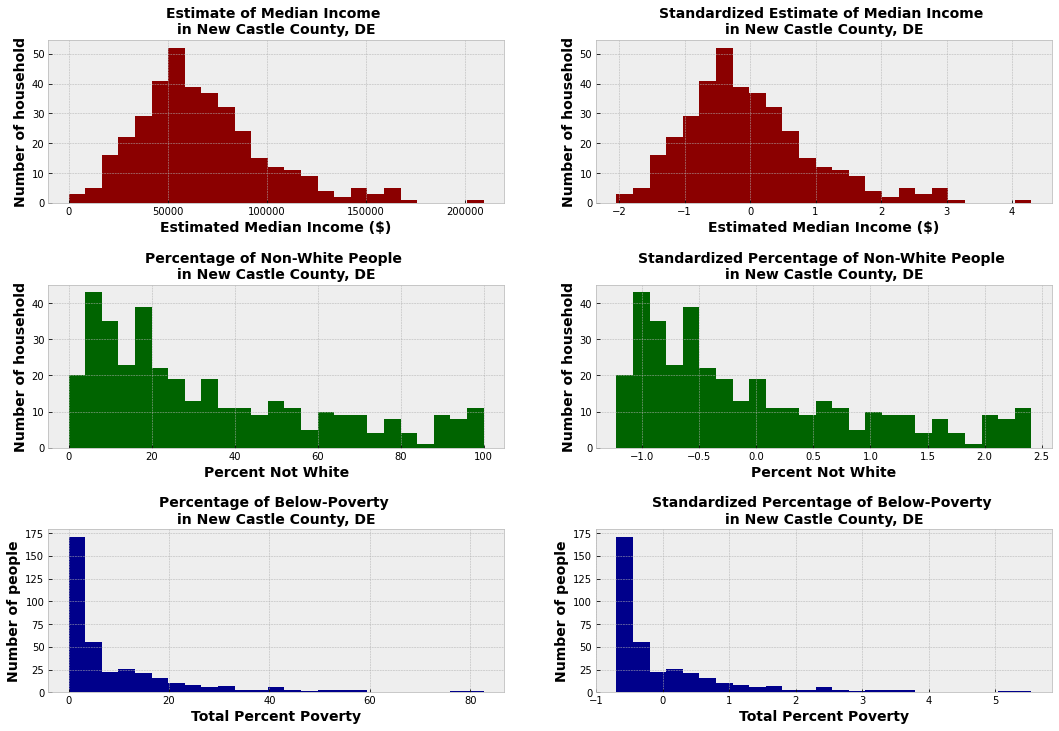

In [17]:
# Figure
fig_nc_demo, ax=plt.subplots(nrows=3, ncols=2, figsize=[18, 12])
plot1 = ax[0,0]
plot2 = ax[0,1]
plot3 = ax[1,0]
plot4 = ax[1,1]
plot5 = ax[2,0]
plot6 = ax[2,1]


nc_demo.hist('mincome', ax=plot1, bins=25, color="darkred")
label_plot(plot1, "Estimate of Median Income \nin New Castle County, DE", "Estimated Median Income ($)", "Number of household", axis_size=14, title_size=14)
nc_demo.hist('mincome_st', ax=plot2, bins=25, color="darkred")
label_plot(plot2, "Standardized Estimate of Median Income \nin New Castle County, DE", "Estimated Median Income ($)", "Number of household", title_size=14, axis_size=14)

nc_demo.hist('per_nonwhite', ax=plot3, bins=25, color="darkgreen")
label_plot(plot3, "Percentage of Non-White People \nin New Castle County, DE", "Percent Not White", "Number of household", axis_size=14, title_size=14)
nc_demo.hist('per_nonwhite_st', ax=plot4, bins=25, color="darkgreen")
label_plot(plot4, "Standardized Percentage of Non-White People \nin New Castle County, DE", "Percent Not White", "Number of household", title_size=14, axis_size=14)

nc_demo.hist('per_below_povlev', ax=plot5, bins=25, color="darkblue")
label_plot(plot5, "Percentage of Below-Poverty \nin New Castle County, DE", "Total Percent Poverty", "Number of people", axis_size=14, title_size=14)
nc_demo.hist('per_below_povlev_st', ax=plot6, bins=25, color="darkblue")
label_plot(plot6, "Standardized Percentage of Below-Poverty \nin New Castle County, DE", "Total Percent Poverty", "Number of people", title_size=14, axis_size=14)

fig_nc_demo.subplots_adjust(wspace=.2, hspace=.5)
fig_nc_demo.show()

**Fig 3 Socioeconomic demographic (SED) status** Subtitle is the socioeconomic demographic status in New Castle County. The data is estimated from 2014 to 2018 and the data source is from the U.S. Census Bureau. In this figure, the mean of the median household income is $6,7356, the mean of the percentage of not white people is 33.7%, and the rate of the total percentage of poverty is 9.2%.   

# Geocoding: Raster data to Census block group shapefile, Shapefile to SES data


## Set GEOID & Merge dataframe

In [18]:
# income
geoids = []
for cgeo in nc_income_cblkg.index:
  geoids.append(cgeo.geo[0][1] + cgeo.geo[1][1] + cgeo.geo[2][1] + cgeo.geo[3][1])
nc_income_cblkg["cblockgid"] = geoids

# race 
geoids = []
for cgeo in nc_race_cblkg.index:
  geoids.append(cgeo.geo[0][1] + cgeo.geo[1][1] + cgeo.geo[2][1] + cgeo.geo[3][1])
nc_race_cblkg["cblockgid"] = geoids

# poverty
geoids = []
for cgeo in nc_poverty_cblkg.index:
  geoids.append(cgeo.geo[0][1] + cgeo.geo[1][1] + cgeo.geo[2][1] + cgeo.geo[3][1])
nc_poverty_cblkg["cblockgid"] = geoids

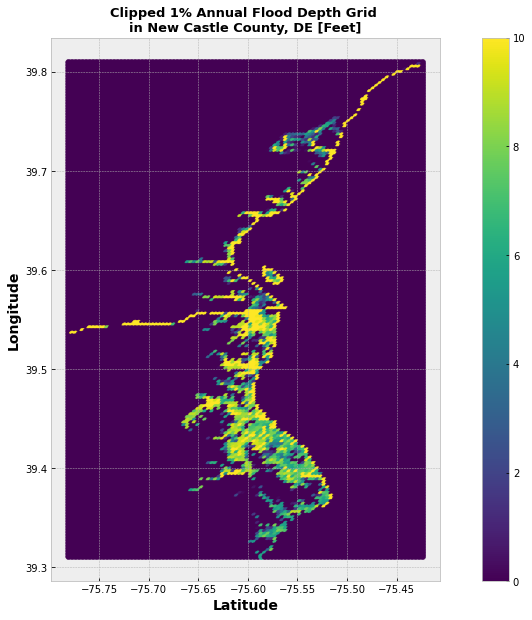

In [19]:
# Raster data preprocessing 
df_dgrid_3c = pd.DataFrame(columns=["lat", "lon", "dep"])
#dep_grid_3c = arr3C_Cst_Dpth01pct
df_dgrid_3c["lat"] = lat_grid_3c.flatten()
df_dgrid_3c["lon"] = lon_grid_3c.flatten()
df_dgrid_3c["dep"] = dep_grid_3c.flatten().astype(float)
def make_point(x):
  return Point(x["lon"], x["lat"])
  make_point(df_dgrid.iloc[0])
df_dgrid_3c["geometry"] = df_dgrid_3c.apply(make_point, axis=1)
df_dgrid = df_dgrid_3c
df_dgrid

df_dgrid_3c = gp.GeoDataFrame(df_dgrid_3c)
df_dgrid = gp.GeoDataFrame(df_dgrid)

#Figure
fig_df_dgrid, ax = plt.subplots()
df_dgrid.plot("dep", ax=ax, legend=True)
label_plot(ax, "Clipped 1% Annual Flood Depth Grid \nin New Castle County, DE [Feet]", "Latitude", "Longitude", axis_size=14, title_size=13)

fig_df_dgrid.savefig("/content/drive/My Drive/flooding/figure/sppa667")

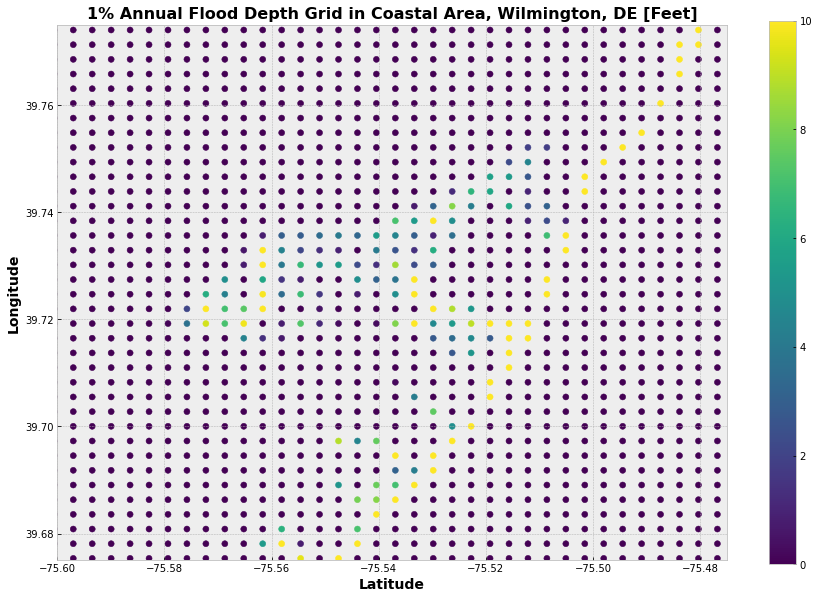

In [20]:
# Wilmington figure
df_dgrid_copy = df_dgrid.copy()

fig_df_dgrid_wm, ax = plt.subplots()
df_dgrid_copy.plot("dep", ax=ax, legend=True)
ax.set_xlim(-75.6, -75.475)
ax.set_ylim(39.675, 39.775)
label_plot(ax, "1% Annual Flood Depth Grid in Coastal Area, Wilmington, DE [Feet]", "Latitude", "Longitude", axis_size=14, title_size=16)

fig_df_dgrid_wm.savefig("/content/drive/My Drive/flooding/figure/sppa667")

**Fig 4. Flood Depth Grid with Latitude and Longitude** Subtitle is the 1% Annual Flood Depth Grid in Coastal Area, Wilmington, Delaware (Unit:Feet). The data is based on the 2014 raster data from the FEMA. The figure above shows the 1% annual flood depth grid clipped from 0 to 1. The figure shows that the local area surrounded by the Delaware River has the flood risk. 


## Geospatial join raster data to census  shapefile

In [21]:
# Perform a spatial join between the Raster data and Census block shape file
df_dgrid_3c_decblkg_2010 = gp.sjoin(df_dgrid_3c, decblkg_2010)
df_dgrid_decblkg_2010 = df_dgrid_3c_decblkg_2010

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  


In [22]:
# get the average number of depth 
df_dgrid_3c_decblkg_2010["dep_cl"] = df_dgrid_3c_decblkg_2010["dep"].clip(0, 1e6)
df_dgrid_g = df_dgrid_3c_decblkg_2010.groupby("GEOID10").mean().reset_index()
cols = ["GEOID10", "lat", "lon", "dep", "dep_cl"]
df_dgrid_sub = df_dgrid_g[cols]

# Merge 
decblkg_2010_df_dgrid_sub = decblkg_2010.merge(df_dgrid_sub, on="GEOID10")
cols = ["GEOID10", "lat", "lon", "dep", "dep_cl", "geometry"]
decblkg_2010_df_dgrid_sub_cols = decblkg_2010_df_dgrid_sub[cols]

## Merge geodata to SED factors data 

In [23]:
# New Castle
decblkg_2010_df_dgrid_sub_cols_nc_demo = decblkg_2010_df_dgrid_sub_cols.merge(nc_demo, left_on="GEOID10", right_on="cblockgid",how="left")
nc_data = decblkg_2010_df_dgrid_sub_cols_nc_demo
cols = ["cblockgid", "geometry", "lat", "lon", 
        "dep", "dep_cl",
        "mincome", "mincome_st", 
        "per_nonwhite", "per_nonwhite_st",  
        "per_below_povlev", "per_below_povlev_st"]
nc_data_sub = nc_data[cols]
nc_data_sub.columns = ["cblockgid", "geometry", "lat", "lon", 
                    "dep", "dep_cl", "mincome", "mincome_st", "per_nonwhite", "per_nonwhite_st", "per_below_povlev", "per_below_povlev_st"]
nc_data_sub = nc_data_sub.dropna()

# Making a single plot 


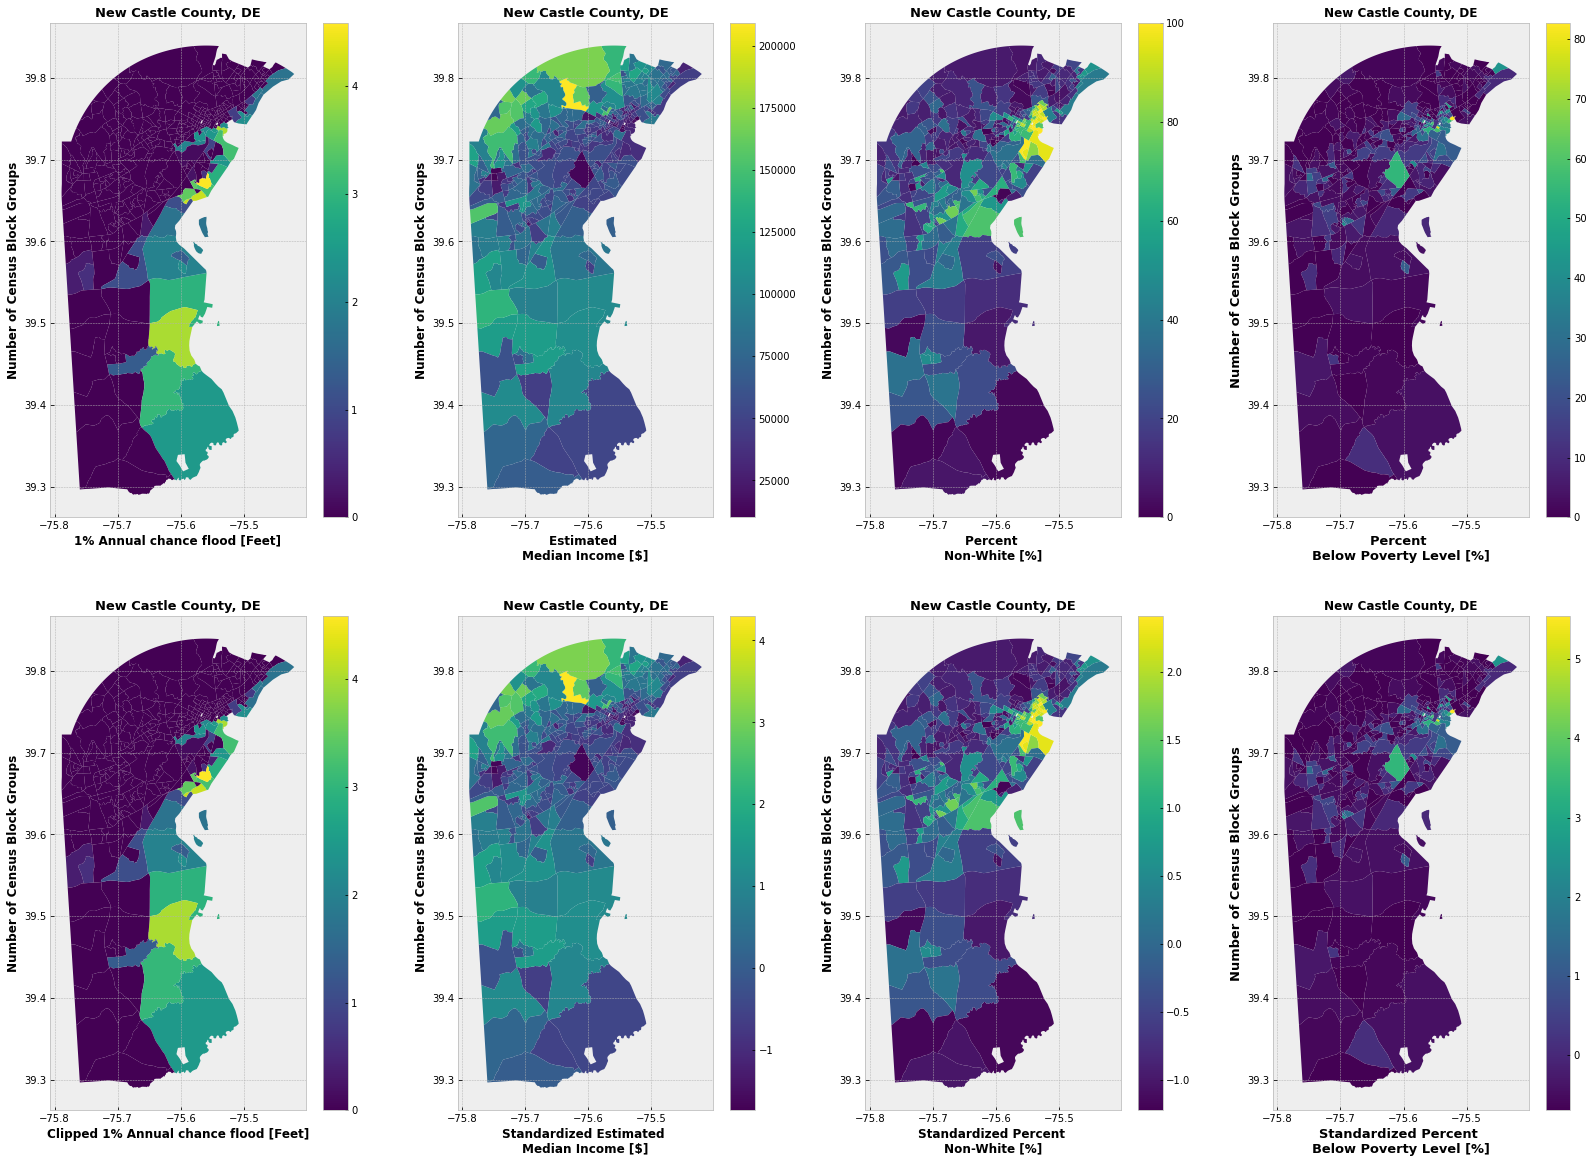

In [24]:
# Plot
fig_nc_data_sub, ax=plt.subplots(nrows=2, ncols=4, figsize=[28, 20])
plot1 = ax[0,0]
plot2 = ax[0,1]
plot3 = ax[0,2]
plot4 = ax[0,3]
plot5 = ax[1,0]
plot6 = ax[1,1]
plot7 = ax[1,2]
plot8 = ax[1,3]

nc_data_sub.plot("dep", ax=plot1, legend=True)
label_plot(plot1, "New Castle County, DE", "1% Annual chance flood [Feet]", "Number of Census Block Groups", axis_size=12, title_size=13)

nc_data_sub.plot("mincome", ax=plot2, legend=True)
label_plot(plot2, "New Castle County, DE", "Estimated \nMedian Income [$]", "Number of Census Block Groups", axis_size=12, title_size=13)

nc_data_sub.plot("per_nonwhite", ax=plot3, legend=True)
label_plot(plot3, "New Castle County, DE", "Percent \nNon-White [%]", "Number of Census Block Groups", axis_size=12, title_size=13)

nc_data_sub.plot("per_below_povlev", ax=plot4, legend=True)
label_plot(plot4, "New Castle County, DE", "Percent \nBelow Poverty Level [%]", "Number of Census Block Groups", title_size=12, axis_size=13)

nc_data_sub.plot("dep_cl", ax=plot5, legend=True)
label_plot(plot5, "New Castle County, DE", "Clipped 1% Annual chance flood [Feet]", "Number of Census Block Groups", axis_size=12, title_size=13)

nc_data_sub.plot("mincome_st", ax=plot6, legend=True)
label_plot(plot6, "New Castle County, DE", "Standardized Estimated \nMedian Income [$]", "Number of Census Block Groups", axis_size=12, title_size=13)

nc_data_sub.plot("per_nonwhite_st", ax=plot7, legend=True)
label_plot(plot7, "New Castle County, DE", "Standardized Percent \nNon-White [%]", "Number of Census Block Groups", axis_size=12, title_size=13)

nc_data_sub.plot("per_below_povlev_st", ax=plot8, legend=True)
label_plot(plot8, "New Castle County, DE", "Standardized Percent \nBelow Poverty Level [%]", "Number of Census Block Groups", title_size=12, axis_size=13)

fig_nc_data_sub.show()
fig_nc_data_sub.savefig("/content/drive/My Drive/flooding/figure/sppa667")

In [25]:
nc_data_sub_copy = nc_data_sub.copy()
nc_data_sub_copy.geometry.total_bounds

array([-75.789023,  39.290281, -75.420056,  39.839516])

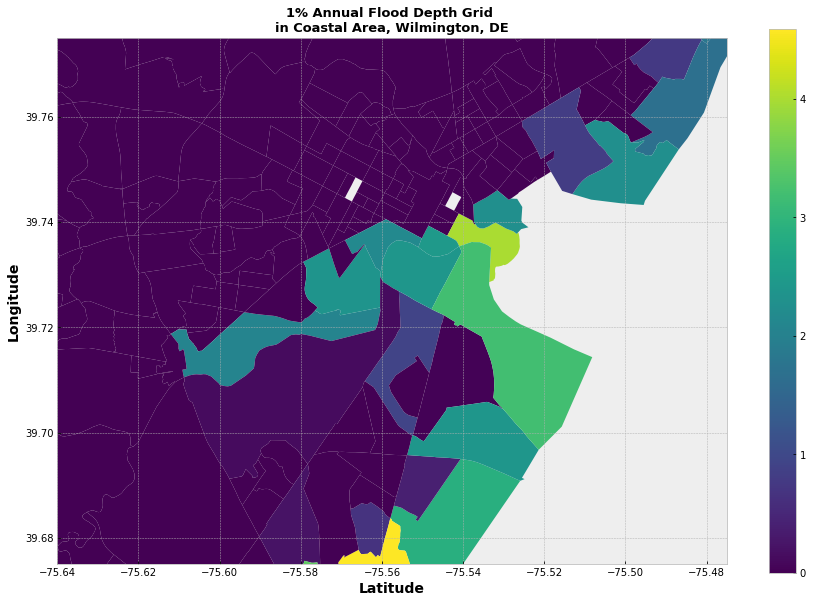

In [26]:
ax = nc_data_sub_copy.plot("dep", legend=True)
ax.set_xlim(-75.64, -75.475)
ax.set_ylim(39.675, 39.775)
label_plot(ax, "1% Annual Flood Depth Grid \nin Coastal Area, Wilmington, DE", "Latitude", "Longitude", axis_size=14, title_size=13)

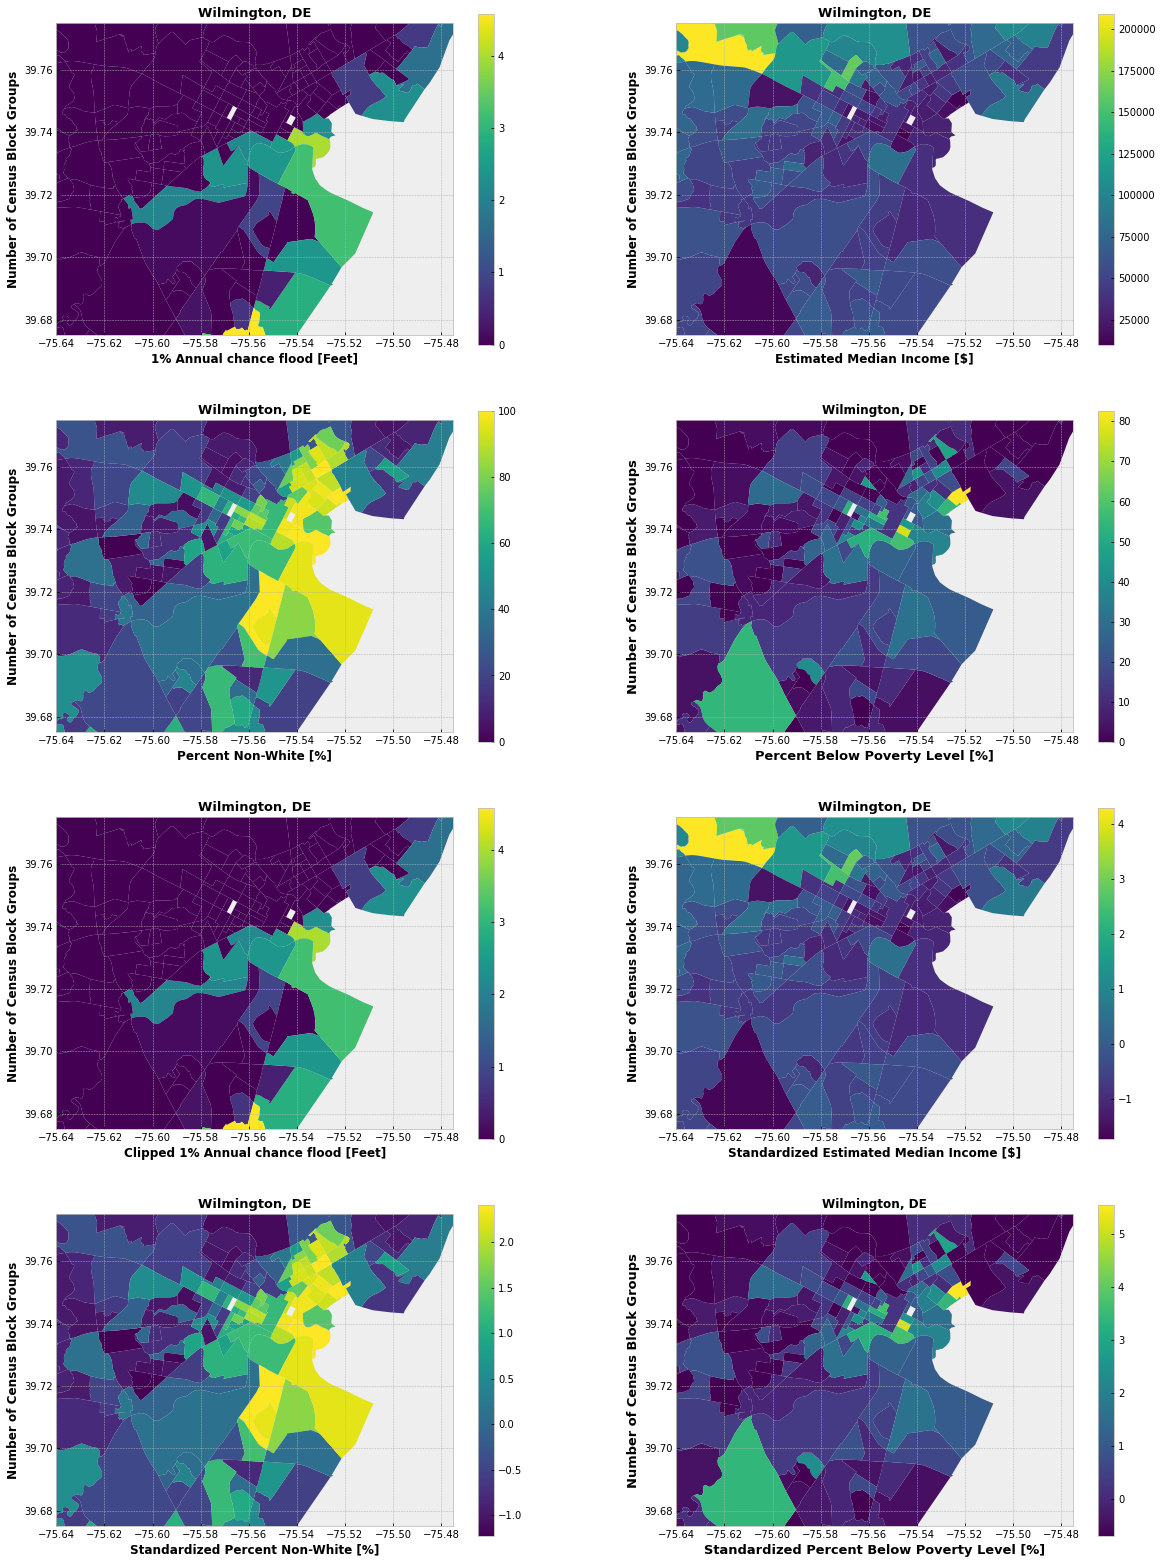

In [27]:
# Plot
fig_nc_data_sub_wm, ax=plt.subplots(nrows=4, ncols=2, figsize=[20, 28])
plot1 = ax[0,0]
plot2 = ax[0,1]
plot3 = ax[1,0]
plot4 = ax[1,1]
plot5 = ax[2,0]
plot6 = ax[2,1]
plot7 = ax[3,0]
plot8 = ax[3,1]

nc_data_sub_copy.plot("dep", ax=plot1, legend=True)
plot1.set_xlim(-75.64, -75.475)
plot1.set_ylim(39.675, 39.775)
label_plot(plot1, "Wilmington, DE", "1% Annual chance flood [Feet]", "Number of Census Block Groups", axis_size=12, title_size=13)

nc_data_sub_copy.plot("mincome", ax=plot2, legend=True)
plot2.set_xlim(-75.64, -75.475)
plot2.set_ylim(39.675, 39.775)
label_plot(plot2, "Wilmington, DE", "Estimated Median Income [$]", "Number of Census Block Groups", axis_size=12, title_size=13)

nc_data_sub_copy.plot("per_nonwhite", ax=plot3, legend=True)
plot3.set_xlim(-75.64, -75.475)
plot3.set_ylim(39.675, 39.775)
label_plot(plot3, "Wilmington, DE", "Percent Non-White [%]", "Number of Census Block Groups", axis_size=12, title_size=13)

nc_data_sub_copy.plot("per_below_povlev", ax=plot4, legend=True)
plot4.set_xlim(-75.64, -75.475)
plot4.set_ylim(39.675, 39.775)
label_plot(plot4, "Wilmington, DE", "Percent Below Poverty Level [%]", "Number of Census Block Groups", title_size=12, axis_size=13)

nc_data_sub_copy.plot("dep_cl", ax=plot5, legend=True)
plot5.set_xlim(-75.64, -75.475)
plot5.set_ylim(39.675, 39.775)
label_plot(plot5, "Wilmington, DE", "Clipped 1% Annual chance flood [Feet]", "Number of Census Block Groups", axis_size=12, title_size=13)

nc_data_sub_copy.plot("mincome_st", ax=plot6, legend=True)
plot6.set_xlim(-75.64, -75.475)
plot6.set_ylim(39.675, 39.775)
label_plot(plot6, "Wilmington, DE", "Standardized Estimated Median Income [$]", "Number of Census Block Groups", axis_size=12, title_size=13)

nc_data_sub_copy.plot("per_nonwhite_st", ax=plot7, legend=True)
plot7.set_xlim(-75.64, -75.475)
plot7.set_ylim(39.675, 39.775)
label_plot(plot7, "Wilmington, DE", "Standardized Percent Non-White [%]", "Number of Census Block Groups", axis_size=12, title_size=13)

nc_data_sub_copy.plot("per_below_povlev_st", ax=plot8, legend=True)
plot8.set_xlim(-75.64, -75.475)
plot8.set_ylim(39.675, 39.775)
label_plot(plot8, "Wilmington, DE", "Standardized Percent Below Poverty Level [%]", "Number of Census Block Groups", title_size=12, axis_size=13)

fig_nc_data_sub_wm.subplots_adjust(wspace=.25)
fig_nc_data_sub_wm.show()

fig_nc_data_sub_wm.savefig("/content/drive/My Drive/flooding/figure/sppa667")

**Fig 5. Flood depth and SED results** Subtitle is the 1% Annual Flood Depth Grid and Socioeconomic Demographic Status in Coastal Area, Wilmington, Delaware. The figure above shows the urban area around the Delaware River in the city is exposed to the 1% annual flood risk. This area is surrounded by the minority who are under average medeian household income, not white, and below povert line. 

**Discussion and Conclusion** Through this project (homework 9), I found the area where the minority relatively lives more than the other area has more possibilities to expose to the flood risk. This issue can be related to the environmental justice, and therefore I look forward to make policy implications based on the data in terms of the data science and urban policy integration. However, this research still has the limitation in that the most recent data of the flood depth is based on 2014 and county level.


# Machine Learning


In [69]:
def standardize_df(dataframe):
  frame_st = pd.DataFrame()
  df_cols = dataframe.columns.to_list()
  for i in df_cols:
    values=dataframe[i].astype(float)
    values_mean = values.mean()
    values_stdev = values.std()
    new_col_name = i+"_st"
    standardized_values=[]
    for x in values:
      standardized_values.append((x-values_mean)/values_stdev)
    frame_st[new_col_name] = standardized_values
  return frame_st

In [70]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

plt.style.use("bmh")

In [71]:
data = nc_data_sub_copy
data.columns

Index(['cblockgid', 'geometry', 'lat', 'lon', 'dep', 'dep_cl', 'mincome',
       'mincome_st', 'per_nonwhite', 'per_nonwhite_st', 'per_below_povlev',
       'per_below_povlev_st', 'fld_present'],
      dtype='object')

##Data reframe

In [72]:
# Set dataframe

fld_unshuffled = data


fld_values = fld_unshuffled['dep_cl'].values

fld_class_groups = []
for i in fld_values:
  if i == 0:
    fld_class_groups.append(0)
  else:
    fld_class_groups.append(1)

fld_unshuffled['fld_present'] = fld_class_groups

# Set 0 and 1 values 
fld_unshuffled_yes = fld_unshuffled[fld_unshuffled['fld_present']==1].copy()
len(fld_unshuffled_yes)
num_yes = len(fld_unshuffled_yes)

fld_unshuffled_no = fld_unshuffled[fld_unshuffled['fld_present']==0].copy()
len(fld_unshuffled_no)
num_no = fld_unshuffled_no.sample(frac=1, random_state=32)

fld_no_bal = fld_unshuffled_no[:num_yes]
#fld_no_bal = fld_shuffle_no[:num_yes]
fld_bal_unshuffled = fld_unshuffled_yes.append(fld_no_bal)
fld_bal_shuffle = fld_bal_unshuffled.sample(frac=1, random_state=17)
fld_bal_shuffle.columns



Index(['cblockgid', 'geometry', 'lat', 'lon', 'dep', 'dep_cl', 'mincome',
       'mincome_st', 'per_nonwhite', 'per_nonwhite_st', 'per_below_povlev',
       'per_below_povlev_st', 'fld_present'],
      dtype='object')

##1) Random Forest Classifier

Random Forest Classifier
* Objects: Census block groups
* Features:Estimated median income, Percent of population that is not white, Percent of people below the poverty line
* Target: Presence or absence of flood risk (Binary)

In [73]:
# Set feature, target

feat_fld_class = fld_bal_shuffle[['mincome',
       'mincome_st', 'per_nonwhite', 'per_nonwhite_st', 'per_below_povlev',
       'per_below_povlev_st']].copy()
targ_fld_class = fld_bal_shuffle["fld_present"].values

feat_tr_fld_class, feat_te_fld_class, targ_tr_fld_class, targ_te_fld_class = train_test_split(feat_fld_class, targ_fld_class, test_size=0.2, random_state=71)



In [74]:
rfc_fld_init = RandomForestClassifier(random_state=314)
rfc_fld_init.fit(feat_tr_fld_class, targ_tr_fld_class)

pred_tr_fld_class = rfc_fld_init.predict(feat_tr_fld_class)
pred_te_fld_class = rfc_fld_init.predict(feat_te_fld_class)

fld_tr_acc_init = accuracy_score(targ_tr_fld_class, pred_tr_fld_class)
fld_te_acc_init = accuracy_score(targ_te_fld_class, pred_te_fld_class)



In [75]:
rfc_fld_best = RandomForestClassifier(random_state=314, max_depth=13, max_features=4, min_samples_leaf=65)
rfc_fld_best.fit(feat_tr_fld_class, targ_tr_fld_class)

pred_tr_fld_class_best = rfc_fld_best.predict(feat_tr_fld_class)
pred_te_fld_class_best = rfc_fld_best.predict(feat_te_fld_class)

fld_tr_acc_best = accuracy_score(targ_tr_fld_class, pred_tr_fld_class_best)
fld_te_acc_best = accuracy_score(targ_te_fld_class, pred_te_fld_class_best)



In [76]:
importances_fld_class = rfc_fld_best.feature_importances_

imp_fld_class = pd.DataFrame()
imp_fld_class["Feature"] = feat_fld_class.columns
imp_fld_class["Importance"] = importances_fld_class
imp_fld_class =imp_fld_class.sort_values("Importance", ascending=False)

In [77]:
# Feature
feat_fld_class.columns

feat_fld_class_nondemographic = feat_fld_class[['mincome', 'mincome_st', 'per_nonwhite', 'per_nonwhite_st',
       'per_below_povlev', 'per_below_povlev_st']].copy()
feat_fld_class_nondem = standardize_df(feat_fld_class_nondemographic)
feat_tr_fld_class_nondem, feat_te_fld_class_nondem, targ_tr_fld_class, targ_te_fld_class = train_test_split(feat_fld_class_nondemographic, targ_fld_class, test_size=0.2, random_state=71)

In [78]:

rfc_fld_init_nondem = RandomForestClassifier(random_state=314, max_depth=13, max_features=4, min_samples_leaf=90)
rfc_fld_init_nondem.fit(feat_tr_fld_class_nondem, targ_tr_fld_class)

pred_tr_fld_class_nondem = rfc_fld_init_nondem.predict(feat_tr_fld_class_nondem)
pred_te_fld_class_nondem = rfc_fld_init_nondem.predict(feat_te_fld_class_nondem)

fld_tr_acc_init_nondem = accuracy_score(targ_tr_fld_class, pred_tr_fld_class_nondem)
fld_te_acc_init_nondem = accuracy_score(targ_te_fld_class, pred_te_fld_class_nondem)

feat_fld_class_st = standardize_df(feat_fld_class)
feat_tr_fld_st, feat_te_fld_st, targ_tr_fld_class, targ_te_fld_class = train_test_split(feat_fld_class_st, targ_fld_class, test_size=0.2, random_state=71)

In [87]:
print("Initial RFC Model (all features) Results:")
print("Initial RFC model (all features) training accuracy: " + str(fld_tr_acc_init))
print("Initial RFC model (all features) testing accuracy: " + str(fld_te_acc_init))
print("\n")
print("Final RFC Model (all features) Results: ")
print("Final RFC model (all features) training accuracy: " + str(fld_tr_acc_best))
print("Final RFC model (all features) testing accuracy: " + str(fld_te_acc_best))
print("\n")
print("Importances for final RFC model (all features):")
print(imp_fld_class)
print("\n")
print("Final RFC Model (without SES features) Results:")
print("Final RFC model training accuracy (without SES features): " + str(fld_tr_acc_init_nondem))
print("Final RFC model testing accuracy (without SES features): " + str(fld_te_acc_init_nondem))
print("\n")
print("RFC Model Comparison:")
print("Percent change in testing accuracy with addition of SES features: " + str(((fld_te_acc_best - fld_te_acc_init_nondem)/fld_te_acc_init_nondem)*100)[:5] + "%")
print("\n")

Initial RFC Model (all features) Results:
Initial RFC model (all features) training accuracy: 1.0
Initial RFC model (all features) testing accuracy: 0.4117647058823529


Final RFC Model (all features) Results: 
Final RFC model (all features) training accuracy: 0.5076923076923077
Final RFC model (all features) testing accuracy: 0.47058823529411764


Importances for final RFC model (all features):
               Feature  Importance
0              mincome         0.0
1           mincome_st         0.0
2         per_nonwhite         0.0
3      per_nonwhite_st         0.0
4     per_below_povlev         0.0
5  per_below_povlev_st         0.0


Final RFC Model (without SES features) Results:
Final RFC model training accuracy (without SES features): 0.5076923076923077
Final RFC model testing accuracy (without SES features): 0.47058823529411764


RFC Model Comparison:
Percent change in testing accuracy with addition of SES features: 0.0%




##2) Logistic Regression Classification

Logistic Regression
* Objects: Census block groups
* Features:Estimated median income, Percent of population that is not white, Percent of people below the poverty line
* Target: Presence or absence of flood risk (Binary)


In [79]:
# Logistic regression
lr_fld = LogisticRegression(random_state=314)
lr_fld.fit(feat_tr_fld_st, targ_tr_fld_class)

pred_lr_fld_tr = lr_fld.predict(feat_tr_fld_st)
pred_lr_fld_te = lr_fld.predict(feat_te_fld_st)

lr_fld_tr_acc_init = accuracy_score(targ_tr_fld_class, pred_lr_fld_tr)
lr_fld_te_acc_init = accuracy_score(targ_te_fld_class, pred_lr_fld_te)

In [80]:
# Coefficient
coefficients_fld_class = lr_fld.coef_[0]
lr_fld_coef= pd.DataFrame()
lr_fld_coef["Feature"] = feat_fld_class.columns
lr_fld_coef["Coefficient"] = coefficients_fld_class
lr_fld_coef["abs"] = lr_fld_coef["Coefficient"].abs()
lr_fld_coef =lr_fld_coef.sort_values("abs", ascending=False)
lr_fld_coef = lr_fld_coef[["Feature", "Coefficient"]]

In [81]:
feat_fld_class.columns

Index(['mincome', 'mincome_st', 'per_nonwhite', 'per_nonwhite_st',
       'per_below_povlev', 'per_below_povlev_st'],
      dtype='object')

In [82]:

feat_fld_class_nondemographic = feat_fld_class[['mincome', 'mincome_st', 'per_nonwhite', 'per_nonwhite_st',
       'per_below_povlev', 'per_below_povlev_st']].copy()
feat_fld_class_nondem = standardize_df(feat_fld_class_nondemographic)
feat_tr_fld_nondem_st, feat_te_fld_nondem_st, targ_tr_fld_nondem_class, targ_te_fld_nondem_class = train_test_split(feat_fld_class_nondem, targ_fld_class, test_size=0.2, random_state=71)

In [83]:
lr_fld_nondem = LogisticRegression(random_state=314)
lr_fld_nondem.fit(feat_tr_fld_nondem_st, targ_tr_fld_nondem_class)

pred_lr_fld_nondem_tr = lr_fld_nondem.predict(feat_tr_fld_nondem_st)
pred_lr_fld_nondem_te = lr_fld_nondem.predict(feat_te_fld_nondem_st)

lr_fld_tr_acc_nondem = accuracy_score(targ_tr_fld_class, pred_lr_fld_nondem_tr)
lr_fld_te_acc_nondem = accuracy_score(targ_te_fld_class, pred_lr_fld_nondem_te)

In [86]:
print("Final Logistic Regression (LR) Model (all features) Results:")
print("Final LR model (all features) training accuracy:" + str(lr_fld_tr_acc_init)[:5])
print("Final LR model (all features) testing accuracy:" + str(lr_fld_te_acc_init)[:5])
print("\n")
print("Final LR Model (without SES features) Results:")
print("Final LR model (without SES features) training accuracy:" + str(lr_fld_tr_acc_nondem)[:5])
print("Final LR model (without SES features) testing accuracy:" + str(lr_fld_te_acc_nondem)[:5])
print("\n")
print("Percent change in testing accuracy with addition of SES features: " + str(((lr_fld_te_acc_init - lr_fld_te_acc_nondem)/lr_fld_te_acc_nondem)*100)[:5] + "%")

Final Logistic Regression (LR) Model (all features) Results:
Final LR model (all features) training accuracy:0.6
Final LR model (all features) testing accuracy:0.705


Final LR Model (without SES features) Results:
Final LR model (without SES features) training accuracy:0.6
Final LR model (without SES features) testing accuracy:0.705


Percent change in testing accuracy with addition of SES features: 0.0%
